# Overland Flow Explorer
- Check and explore overland flow for the test run 24 hours. 
- Matched with USGS gages and `NWM_Gage_Adjustments_final.csv` and discovered that not all gages listed in this CSV have flow in CONUS2.  
    - Tried to figure out why this is, made masks of these gages for QGIS
- Compared CONUS2 with USGS flow at random gages

### Import Packages
Here we will be using the reading and writing tools that come with the ParFlow tools package.  

## Old code, can start at "Read in Daily Flow Files" cell

In [1]:
import xarray as xr
import numpy as np
import os
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import figure
import pandas as pd
from osgeo import gdal


import parflow as pf
from parflow.tools.fs import get_absolute_path
from parflow.tools.io import write_pfb, read_pfb
from parflow import Run
import parflow.tools.hydrology as hydro

#setting the directory name that we will read our outputs from
run_name = 'spinup.wy2003'
run_dir = '/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs'
print(run_dir)

/glade/scratch/tijerina/CONUS2/spinup_WY2003/run_inputs


#### Read in the domain properties
- Outputs are from a test simulation of 24 hours from the scaling study

In [2]:
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
nt = len(data.times)
nx = data.shape[2]
ny = data.shape[1]
nz = data.shape[0]
dx = data.dx
dy = data.dy
dz = data.dz

print(nt,nx,ny,nz,dx,dy,dz)

porosity = data.computed_porosity 
specific_storage = data.specific_storage 
#mannings = pf.read_pfb(f'{run_dir}/spinup.scaling.48_36.out.n.pfb') #run.Mannings.Geom.domain.Value
mannings = data.mannings

## remove input filenames for TopoSlopes to force the data accessor to read the output slopes
## this fixes a windows issue
run.TopoSlopesX.FileName = None
run.TopoSlopesY.FileName = None

slopex = data.slope_x 
slopey = data.slope_y 
mask = data.mask

# formatting the mask so that values outside the domain are NA and inside the domain are 1
# check with mask that has 0 and 1
nanmask=mask.copy()
#nanmask[nanmask == 0] = 'NaN' ---> Use this for NaNs np.nan
nanmask[nanmask > 0] = 1

Solver: Field BinaryOutDir is not part of the expected schema <class 'parflow.tools.database.generated.Solver'>
Solver.OverlandKinematic: Field SeepageOne is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
Solver.OverlandKinematic: Field SeepageTwo is not part of the expected schema <class 'parflow.tools.database.generated.OverlandKinematic'>
  - nt
  - sw_ini
  - hkdepth
  - wtfact
  - trsmx0
  - smpmax
  - pondmx
0 4442 3256 10 1000.0 1000.0 [2.0e+02 1.0e+02 5.0e+01 2.5e+01 1.0e+01 5.0e+00 1.0e+00 6.0e-01 3.0e-01
 1.0e-01]


#### Read the simulation output files

In [ ]:
#list all pressure files from outputs
lw_press_files = glob(f'{run_dir}/*out.press*.pfb')
#print(lw_press_files)
#read in all pressure files into a 3D NParray
pressure_arrays = pf.read_pfb_sequence(lw_press_files) * nanmask

#list all saturation files from outputs
lw_satur_files = glob(f'{run_dir}/*out.satur*.pfb')
#read in all pressure files into a 3D NParray
saturation_arrays = pf.read_pfb_sequence(lw_satur_files) * nanmask

In [ ]:
pressure_arrays.shape

## Read in daily flow files (from Organize_Streamflow.ipynb)

In [6]:
import sys
from parflow.tools.io import read_pfb,write_pfb
from parflow import Run
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


### Directory where PF flow PFBs are saved in
directory_out = '/glade/p/univ/ucsm0002/CONUS2/CONUS2.spinup.WY2003/averages'
organized_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Organized_Daily_Flow'
### Where you want to save plots, etc. to
plot_dir = '/glade/work/tijerina/PFCONUS2-analysis/scripts/Validation/Streamflow/Figures'
### name of USGS observation csv
#usgs_data = 'USGS_WY2003_oct_mean_flow.csv' #csv of USGS flow from hydrodata

### need to change water year and number of days
water_year = 2003
no_days = 31 

### check gage locations for daily flow
NWM_gage_csv = pd.read_csv('/glade/p/univ/ucsm0002/CONUS2/domain_files/NWM_Gage_Adjustments_final.csv')


### pfidb mask (for plotting with mask below)
#setting the directory name that we will read our outputs from
run_name = 'spinup.wy2003'
run_dir = '/glade/p/univ/ucsm0002/CONUS2/CONUS2.spinup.WY2003/run_inputs'
run = Run.from_definition(f'{run_dir}/{run_name}.pfidb')
data = run.data_accessor
mask = data.mask
# make mask that has 0 and 1
newmask=mask.copy()
#nanmask[nanmask == 0] = 'NaN' ---> Use this for NaNs np.nan
newmask[newmask > 0] = 1


### Domain properties
ny = 3256
nx = 4442
days = 31
pf_grid_flow = np.zeros((days,ny,nx))
pf_grid_flow.shape

In [7]:
### set up pandas dataframe of gage ID, lat/long, CONUS2 x and y indices ###
pf_flow_df = pd.DataFrame(columns = ['STNID', 'USGS_lat', 'USGS_lon', 'x_new_adj', 'y_new_adj'])
pf_flow_df['STNID'] = NWM_gage_csv['STNID'].astype(int)
pf_flow_df['USGS_lat'] = NWM_gage_csv['USGS_lat']
pf_flow_df['USGS_lon'] = NWM_gage_csv['USGS_lon']
pf_flow_df['x_new_adj'] = NWM_gage_csv['x_new_adj']
pf_flow_df['y_new_adj'] = NWM_gage_csv['y_new_adj']

# add leading zeros to USGS gages
pf_flow_df['STNID'] = pf_flow_df['STNID'].astype('str').str.zfill(8)

pf_flow_df.head()

,STNID,USGS_lat,USGS_lon,x_new_adj,y_new_adj
0,01011000,47.069611,-69.079544,4210,2783
1,01013500,47.237394,-68.582642,4237,2810
2,01015800,46.523003,-68.371764,4276,2747
3,01017000,46.777294,-68.157194,4281,2773
4,01017060,46.783611,-67.989167,4295,2780


In [8]:
### READ STREAMFLOW PFBs ###
# Read in CONUS2 daily streamflow PFBs and save as df in flow_df, convert to total accumulated in m^3/h to mean daily in cms


for i in range(no_days):
    step = str(int(i+1)).rjust(3, '0')
    pf_grid_flow[i,...] = np.squeeze(read_pfb(f'{directory_out}/flow.2003.daily.{step}.pfb'))
    
    #pf_flow_df[f'day {step}'] = pf_flow_pfb[pf_flow_df['y_new_adj'],pf_flow_df['x_new_adj']]/3600/24 # CONVERT FROM m^3/h to cms AND from daily accumulated to daily mean
    print(f'reading flow for day {step}')

    
# # Create column for matching/have flow (=1) and not matching/have no flow (=0) gages
# pf_flow_df['matched'] = np.where(pf_flow_df['day 001']>0, 1, 0)

# # remove cells with no flow and make new pandas df with matching flow at CONUS2 cells and USGS gages
# pf_flow_df_NWM_match = pf_flow_df[pf_flow_df.matched != 0]

# # SAVE OUT PANDAS DF FOR CONUS2 FLOW
# ### save csv file of all matching gage locations and CONUS2 daily flow, note the USGS STNID's drop the leading zeros when saving
# pf_flow_df_NWM_match.to_csv(f'{organized_dir}/CONUS2_NWM_matched_flow_{water_year}.csv', sep = ",")

reading flow for day 001
reading flow for day 002
reading flow for day 003
reading flow for day 004
reading flow for day 005
reading flow for day 006
reading flow for day 007
reading flow for day 008
reading flow for day 009
reading flow for day 010
reading flow for day 011
reading flow for day 012
reading flow for day 013
reading flow for day 014
reading flow for day 015
reading flow for day 016
reading flow for day 017
reading flow for day 018
reading flow for day 019
reading flow for day 020
reading flow for day 021
reading flow for day 022
reading flow for day 023
reading flow for day 024
reading flow for day 025
reading flow for day 026
reading flow for day 027
reading flow for day 028
reading flow for day 029
reading flow for day 030
reading flow for day 031


In [9]:
# converting from total accumulated flow in m^3/h, to daily mean flow in cms
pf_grid_flow_cms = pf_grid_flow/3600/24

In [10]:
pf_grid_flow_cms_day_avg = np.sum(pf_grid_flow_cms, axis = 0)/days

In [11]:
pf_grid_flow_cms_day_avg.shape

(3256, 4442)

In [12]:
print(pf_grid_flow_cms_day_avg.max())
print(pf_grid_flow_cms_day_avg.min())

18001.781332167368
0.0


## Calculate overlandflow

In [13]:
# overland_flow = np.zeros((216, ny, nx))
# for i in range(216):
#     overland_flow[i,...] = hydro.calculate_overland_flow_grid(pressure_arrays[i,...], slopex, slopey, mannings, dx, dy, mask = nanmask)/3600
#     # divide by 3600 to go from [m^3/h] to [m^3/s]

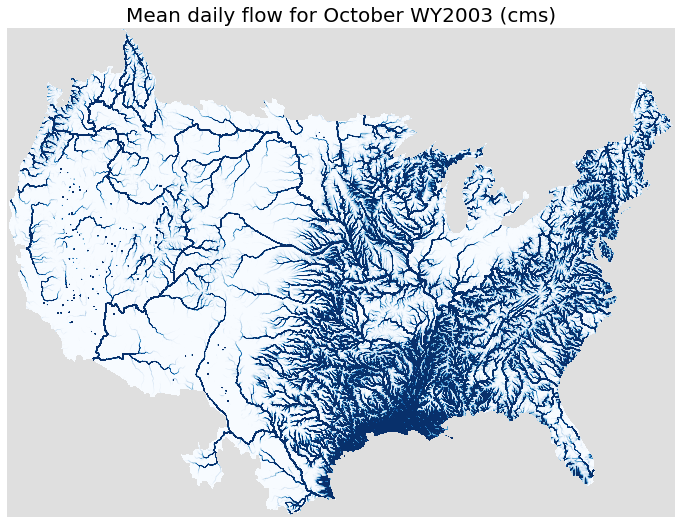

In [20]:
cmap_mask = plt.cm.Reds.copy()
cmap_mask.set_bad(color='grey')
pf_grid_flow_cms_day_avg[newmask[-1,...]==0]=np.nan 

fig = plt.figure(figsize = (12,9))
ax = fig.add_subplot()

ax.imshow(np.ma.masked_array(mask[-1,:,:],mask[-1,:,:]==0),origin='lower',cmap=cmap_mask,alpha=0.25)
ax.imshow(pf_grid_flow_cms_day_avg,origin='lower', cmap='Blues', vmin=0, vmax=0.5)

#ax.imshow(initial[layer,:,:],origin='lower',interpolation=None,vmin=vmin,vmax=vmax,cmap='Blues')
#plt.imshow(np.ma.masked_array(nanmask[-1,:,:],nanmask[-1,:,:]==0),origin='lower',cmap=cmap_mask,alpha=0.6)
#plt.imshow(np.ma.masked_array(pf_grid_flow_cms_day_avg, mask==1),origin='lower', vmax=0.5)
#plt.imshow(pf_grid_flow_cms_day_avg, cmap='Blues', origin='lower', vmin = 0, vmax = 0.5)
plt.axis('off')
#plt.colorbar()
plt.title('Mean daily flow for October WY2003 (cms)', fontsize = 20)

plt.savefig(f'{plot_dir}/Average_daily_flow_for_October_WY2003_cms.png', dpi=300, bbox_inches='tight')

In [26]:
# Just checking what the mask values are
print(np.unique(newmask[-1,:,:]))

[0. 1.]


In [ ]:
# ### sum all hours for daily flow ###
# for i in len(range(24))
# daily_overland_flow = np.sum(overland_flow, axis = 0)

In [ ]:
# plt.figure(figsize = (9,7))
# plt.imshow(daily_overland_flow, cmap="Blues", origin='lower', vmin = 0, vmax = 500)
# plt.colorbar()
# plt.title('Daily Overland Flow')
# #plt.savefig('overlandflow_daily_cms.png', dpi=1000)
# plt.show()

In [ ]:
# Checking min/max/shape (cms)
print('Hourly overland flow (cms): ')
print(f'Shape: {overland_flow.shape}')
print(f'Max: {overland_flow.max()}')
print(f'Min: {overland_flow.min()}')
print(" ")
print('Daily overland flow (cms... not m^3/d?): ')
print(f'Shape: {daily_overland_flow.shape}')
print(f'Max: {daily_overland_flow.max()}')
print(f'Min: {daily_overland_flow.min()}')

# Everything below here is OLD and from the 24-hour test run checks...
###might be useful, might not

### Create overland flow GeoTiff for GIS 
- from `daily_overland_flow` ~ Daily flow in [cms]

In [ ]:
### CREATE GEOTIFF
# this file is needed for the geotransform and projection below
file = '../1km_CONUS2_landcover_IGBP.tif'

# open tiff mask
lc_tif = gdal.Open(file)

type(lc_tif)

In [ ]:
# Flip df to make tif
overland_flow1_flip = np.flipud(daily_overland_flow)

# Create geotiff of CLM variables for QGIS
dst_filename = 'OverlandFlow.tiff'
x_pixels = 4442  # number of grid cells in x
y_pixels = 3256  # number of grid cells in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(overland_flow1_flip) ### create tif with array you want to use

# Add GeoTranform and Projection information to newly created tif file
geotrans=lc_tif.GetGeoTransform()  #get GeoTranform from existing tif file (here 'conus2tiff')
proj=lc_tif.GetProjection() #you can import or get from a existing tif   
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Observations and Gages

#### Find CONUS2 flow at gage locations 
- Read in `NWM_Gage_Adjustments_final.csv` which maps each USGS gage in the domain to the CONUS2 dx, dy grid coordinate
- Make new Pandas df of gage id, coordinates, etc. 
- Add total daily and hourly CONUS2 flow to df

In [ ]:
### check gage locations for daily flow
NWM_gage_csv = pd.read_csv('/glade/work/tijerina/CONUS2_work/data_files/NWM_Gage_Adjustments_final.csv')
print(NWM_gage_csv.shape)
print(NWM_gage_csv.columns)

In [ ]:
### set up pandas data fram of gage ID, lat/long, CONUS2 x and y indices, and CONUS2 flow for one day in cms
flow_at_gages = pd.DataFrame(columns = ['STNID', 'USGS_lat', 'USGS_lon', 'x_new', 'y_new', 'CONUS2_cms'])#np.zeros(len(NWM_gage_csv.index),6)
flow_at_gages['STNID'] = NWM_gage_csv['STNID'].astype(int)
flow_at_gages['USGS_lat'] = NWM_gage_csv['USGS_lat']
flow_at_gages['USGS_lon'] = NWM_gage_csv['USGS_lon']
flow_at_gages['x_new'] = NWM_gage_csv['x_new']-1 # Subtract 1 to align the CONUS grid (starts at 0) and the NWM csv indices (starts at 1)
flow_at_gages['y_new'] = NWM_gage_csv['y_new']-1 # Subtract 1 to align the CONUS grid (starts at 0) and the NWM csv indices (starts at 1)

# add leading zeros to USGS gages
flow_at_gages['STNID'] = flow_at_gages['STNID'].astype('str').str.zfill(8)
#flow_at_gages['STNID'] = NWM_gage_csv['STNID'].astype(int)



In [ ]:
# total CONUS2 daily flow (aggregated hourly flow)
flow_at_gages['CONUS2_cms'] = daily_overland_flow[flow_at_gages['y_new'],flow_at_gages['x_new']] #daily flow in cms

# hourly CONUS2 flow
for i in range(24):
    flow_at_gages[f'hour{i}'] = overland_flow[i,flow_at_gages['y_new'],flow_at_gages['x_new']]

# Create column for matching/have flow (=1) and not matching/have no flow (=0) gages
flow_at_gages['matched'] = np.where(flow_at_gages['CONUS2_cms']>0, 1, 0)

flow_at_gages

In [ ]:
### save txt file of all gage locations and CONUS2 test 24 hours of flow
#THIS DOESN'T WORK UNLESS YOU MAKE USGS GAGES INTO INT, but this also removes leading zeros for gages... (commented out above)
#np.savetxt('CONUS_day_flow_at_gages.txt', flow_at_gages, delimiter=",") 
flow_at_gages.to_csv('CONUS_day_flow_at_gages.csv', sep = ",")

### Create GeoTiffs of gages with and without flow for GIS  

#### Make dataframes including gages with and without flow
- make df's 
- fill arrays with x_new and y_new indices for each to make mask
- create GeoTif of both gages with and without flow

In [ ]:
### Make new df with cells WITH FLOW - rows of zeros removed
# WHY ARE THERE SO MANY GAGES WITH NO FLOW??? (only 2999/7542 have flow)
# NOTE: this has been corrected and now there are 6425/7542 gages with flow. This is because the original NWM_Gage_Adjustments_final.csv x_new and y_new
# started at 1 and the CONUS2 grid starts at 0. The adjustment was made above when setting up the pandas dataframe, subtracting 1 from the x_new and y_new
# of the original csv. Still, some adjustments could be made to match the remaining gages to the correct grid cells: adjusting the x and y actually made
# some gages now incorrect and have no flow.
flow_at_gages_no0 = flow_at_gages[(flow_at_gages[['CONUS2_cms']] != 0).all(axis=1)]
print(flow_at_gages_no0.shape)
flow_at_gages_no0

In [ ]:
### Make new df with only cells with NO FLOW at gages
no_flow_at_gages = flow_at_gages[(flow_at_gages[['CONUS2_cms']] == 0).all(axis=1)]
print(no_flow_at_gages.shape)
no_flow_at_gages

#### fill respective arrays for flow with / without

In [ ]:
### Gages that DO have flow ##
rows = flow_at_gages_no0['y_new']
cols = flow_at_gages_no0['x_new']
gage_match_mask = np.zeros((ny, nx))
gage_match_mask[rows,cols] = 1
np.sum(gage_match_mask)

In [ ]:
# Flip df to make tif
gage_match_mask_flip = np.flipud(gage_match_mask)

# Create geotiff of CLM variables for QGIS
dst_filename = 'CONUS2GagesWithFlow.tiff'
x_pixels = 4442  # number of grid cells in x
y_pixels = 3256  # number of grid cells in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(gage_match_mask_flip) ### create tif with array you want to use

# Add GeoTranform and Projection information to newly created tif file
geotrans=lc_tif.GetGeoTransform()  #get GeoTranform from existing tif file (here 'conus2tiff')
proj=lc_tif.GetProjection() #you can import or get from a existing tif   
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

In [ ]:
### Gages that DON'T have flow ###
rows = no_flow_at_gages['y_new']
cols = no_flow_at_gages['x_new']
no_gage_mask = np.zeros((ny, nx))
no_gage_mask[rows,cols] = 1
np.sum(no_gage_mask)

In [ ]:
# Flip df to make tif
no_gage_mask_flip = np.flipud(no_gage_mask)

# Create geotiff of CLM variables for QGIS
dst_filename = 'CONUS2GagesNoFlow.tiff'
x_pixels = 4442  # number of grid cells in x
y_pixels = 3256  # number of grid cells in y
driver = gdal.GetDriverByName('GTiff')
dataset = driver.Create(dst_filename,x_pixels, y_pixels, 1,gdal.GDT_Float32)
dataset.GetRasterBand(1).WriteArray(no_gage_mask_flip) ### create tif with array you want to use

# Add GeoTranform and Projection information to newly created tif file
geotrans=lc_tif.GetGeoTransform()  #get GeoTranform from existing tif file (here 'conus2tiff')
proj=lc_tif.GetProjection() #you can import or get from a existing tif   
dataset.SetGeoTransform(geotrans)
dataset.SetProjection(proj)
dataset.FlushCache()
dataset=None

## Plot Timeseries of CONUS2 vs Obs

In [ ]:
### read in csv that was just created of gage locations and CONUS2 flow
conus_flow = pd.read_csv('CONUS_day_flow_at_gages.csv', index_col=['STNID'])
conus_flow = conus_flow.drop(columns=['Unnamed: 0','USGS_lat','USGS_lon','x_new','y_new','CONUS2_cms','matched']) #drop unnecessary columns for now
conus_flow = conus_flow.transpose() #transpose df for easier plotting
conus_flow.head()


#### Gage 1: Allagash, Maine

In [ ]:
gage = 1011000
name = 'Allagash River near Allagash, Maine'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import 15-minute streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=29)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
# aggregate 15 min flow into 
d = {'datetime': 'first','discharge (cfs)': 'sum', 'discharge (cms)': 'sum'}
obs_flow = obs_flow.groupby(obs_flow.index // 4).agg(d) #aggregate to hour
obs_flow.head()

In [ ]:
# plot CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

#### Gage 2: WATEREE RIVER NR. CAMDEN, SC

In [ ]:
gage = 6174500
name = 'Milk River at Nashua MT'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
#print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=29)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
### Make a plot of CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

#### Gage 3: KANAWHA RIVER AT CHARLESTON, WV

In [ ]:
gage = 3198000
name = 'KANAWHA RIVER AT CHARLESTON, WV'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import 15-minute streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
#print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=28)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
### Make a plot of CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

#### Gage 4: Mississippi River at St. Louis, MO

In [ ]:
gage = 7010000
name = 'Mississippi River at St. Louis, MO'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
#print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=29)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
### Make a plot of CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

#### Gage 5: SOUTH UMPQUA RIVER NEAR BROCKWAY, OR

In [ ]:
gage = 14312000
name = 'SOUTH UMPQUA RIVER NEAR BROCKWAY, OR'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import 15-minute streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
#print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=29)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
# aggregate 30 min flow into 
d = {'datetime': 'first','discharge (cfs)': 'sum', 'discharge (cms)': 'sum'}
obs_flow = obs_flow.groupby(obs_flow.index // 2).agg(d) #aggregate to hour
obs_flow.head()

In [ ]:
### Make a plot of CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

#### Gage 6: BIG DRY CREEK AT MOUTH NEAR FORT LUPTON, CO

In [ ]:
gage = 6720990
name = 'BIG DRY CREEK AT MOUTH NEAR FORT LUPTON, CO'
################################################

start_date = '2002-10-01'
end_date = '2002-10-01'
gage0 = str(gage).zfill(8) #add leading zeros again (they were dropped when saved to CSV)
# import 15-minute streamflow and gage data #
url = 'https://nwis.waterdata.usgs.gov/usa/nwis/uv/?cb_00060=on&cb_00065=on&format=rdb&site_no='+gage0+'&period=&begin_date='+start_date+'&end_date='+end_date
#print(url)
obs_flow = pd.read_csv(url, sep='\t', skiprows=29)
obs_flow.columns = ['agency','site','datetime','timezone','discharge (cfs)','discharge approval']
print(obs_flow.head())
obs_flow = obs_flow.drop(columns = ['agency', 'site', 'timezone', 'discharge approval'])

#convert cfs to cms
obs_flow['discharge (cms)'] = obs_flow['discharge (cfs)']*0.028316847 

obs_flow.head()

In [ ]:
# aggregate 15 min flow into 
d = {'datetime': 'first','discharge (cfs)': 'sum', 'discharge (cms)': 'sum'}
obs_flow = obs_flow.groupby(obs_flow.index // 4).agg(d) #aggregate to hour
obs_flow.head()

In [ ]:
### Make a plot of CONUS2 vs observed
xlength = range(24)
fig, ax = plt.subplots(figsize=(7,5))
ax.plot(xlength, conus_flow[gage],label= 'CONUS2')
ax.plot(xlength, obs_flow['discharge (cms)'],label= 'USGS')
ax.set_ylabel('flow [cms]')
plt.xlabel('Simulated Hours')
plt.title(f'{name} [cms]')
ax.legend()
#plt.savefig(f'test_{name}_cms.png')

In [ ]:
plt.scatter(np.log10(NWM_gage_csv['ParFlow_DraingeArea']), np.log10(NWM_gage_csv['USGS_DriangeArea']))

#### Plot Static maps of the simulation outputs

In [ ]:
print(np.shape(overland_flow))
print(np.shape(pressure_arrays))

plt.imshow(overland_flow[96,:,:], cmap="Blues", origin='lower', vmin = 0, vmax = 500)
#plt.colorbar()
plt.title('Overland Flow')
plt.show()
plt.imshow(wtd[10,:,:], cmap="Blues_r", origin='lower')
#plt.colorbar()
plt.title('WTD')
plt.show()

#print out all CLM variables avilable
print(data.clm_output_variables)
# set timestep to visualize
data.time = 20
# fileter out inactive cells
LH_plot = np.where(data.clm_output(field='eflx_lh_tot') > -99, data.clm_output(field='eflx_lh_tot'), 0.)
im = plt.imshow(LH_plot, cmap="coolwarm", origin='lower')
#plt.show(im)
plt.title('Latent Heat')
plt.colorbar(im)

#### Plotting components of water balance

In [ ]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Mississippi R at Vicksburg')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,2770, 847], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

In [ ]:
#plotting components of water balance
fig, axs = plt.subplots(4, sharex=True)
fig.suptitle('CONUS2 Water Balance, Clear Creek')
axs[0].plot(subsurface_storage[0:24], linewidth=3, color = "green")
axs[0].set_title("Subsurface Storage")
axs[1].plot(surface_storage[0:24], linewidth=3, color = "blue")
axs[1].set_title("Surface Storage")
axs[2].plot(et[0:24], linewidth=3, color = "orange")
axs[2].set_title("ET")
axs[3].plot(overland_flow[0:24,1528,1679], linewidth=3, color = "red")
axs[3].set_title("Q")
plt.xlabel('Simulated Hours')
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.85, 
                    wspace=0.7, 
                    hspace=1.0)
axs[1].ticklabel_format(axis='y', style='sci', scilimits=(0,0))

#### Save txt files of storage, et, overland flow

In [ ]:
# save out 1D outputs to text files
np.savetxt(f'{run_dir}/water_balance/subsurface_storage_r1_test.txt', subsurface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/surface_storage_r1_test.txt', surface_storage[0:25], delimiter=",")
np.savetxt(f'{run_dir}/water_balance/et_r1_test.txt', et[0:25], delimiter=",")

In [ ]:
# save all 24 timesteps of overland flow to text files
# use zfill to fill 6 digits with leading zeros
for i in range(len(overland_flow[0:25])):
    np.savetxt(f'{run_dir}/water_balance/overland_flow_{str(i).zfill(6)}_r1_test.txt', overland_flow[i,:,:], delimiter=",") 

### Water Balance Calculations

#### 2. Normalize water balance quantities by active CONUS2 area using PFTools ET
Note 7/21 - This I'm not sure is correct. Current logic is that the PFTools outputs ET in a volume, so probably mm^3/s. Multiply this by 3600 s/h to get mm^3/h. Then divide by CONUS2 area, which is converted from km^2 to mm^2 (then you basically have mm^3/s * 1/mm^2). However, if you wanted to really make the units make sense, you would actually divide by 1e12 for km2 to mm2 (not 1e6, which is km to mm).

In [ ]:
et_array = np.loadtxt(f'{run_dir}/water_balance/et_r1_test.txt') #[mm^3/s]
et_array = et_array/1000*3600#[mm^3/s] -> [mm^3/h]
et_array

In [ ]:
cumET = np.cumsum(et_array) # [mm^3/d]
conus_area = 7852823*1e6#km^2 to mm^2 ??? do you also multiply by number of layers because calculate_evapotranspiration() does nx*ny*nz, so *10 ??? 
normET = cumET[-1]/conus_area
print(f'ET over CONUS2 for 24 hour period: {round(normET, 5)} mm/d')

In [ ]:
cumET

#### A. Check ET with clm_output 'qflx_evap_tot'

In [ ]:
# 4: qflx_evap_tot for total evaporation [mm/s]
qflx_evap_CLM = np.zeros((24, ny, nx))
for i in range(24):    
    CLM_file = pf.read_pfb(f'{run_dir}/{run_name}.out.clm_output.{str(i+1).zfill(5)}.C.pfb')
    CLM_file[CLM_file<-9000] = 0 # set values outside of the domain to zero
    qflx_evap_CLM[i, ...] = CLM_file[4,...] # fill qflx_evap_CLM array by flagging the 4 position in the CLM file

In [ ]:
# convert ET from mm/s to mm/h
qflx_evap_CLM = qflx_evap_CLM*3600

# checking evap flux values and make sure that loop worked
print(qflx_evap_CLM.shape)
t = 0 #select timestep (hour) to plot
plt.imshow(qflx_evap_CLM[t,...], origin="lower")
plt.colorbar()
plt.annotate(f'Max: {qflx_evap_CLM[t].max()}', xy = (100,2200))
plt.annotate(f'Min: {qflx_evap_CLM[t].min()}', xy = (100,2000))
plt.title(f'net veg. evaporation and transpiration and soil evaporation (mms-1) for hour {t+1}')

In [ ]:
# sum all cells for every hour to get total hourly ET for entire CONUS2 domain
total_qflx_evap = np.zeros(24)

for i in range(24):
    total_qflx_evap[i] = np.sum(qflx_evap_CLM[i, ...])
plt.scatter(range(24),total_qflx_evap)
plt.xlabel("hours")
plt.ylabel("ET (mm/h)")
plt.title("Total ET over CONUS2 Domain (qflx_evap_tot)")
totalET